In [ ]:
!pip install sklearn_evaluation
!pip install Boruta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR

from sklearn_evaluation import plot
from sklearn.feature_selection import RFE

# for MAE and RMSE calculation
import math
from boruta import BorutaPy

# for Boruta feature importance study
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,RepeatedKFold


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 4.3 MB/s eta 0:0

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
random_state_num = np.random.seed(9291985)

In [ ]:
def plot_mod_eval(ypred_train,ypred_test):
    
    fig, axs = plt.subplots(1,2)
    axs[0].plot( y_train, ypred_train, '^')
    axs[0].set_xlim(-2,1)
    axs[0].set_ylim(-2,1)
    xx = [-2,1]
    yy = [-2,1]
    axs[0].plot(xx, yy)
    axs[0].set_xlabel("$E_{DFT}$ [eV]")
    axs[0].set_ylabel("$E_{pred}$ [eV]")
    axs[0].set_title("training")
    axs[0].set_aspect('equal', 'box')

    axs[1].plot( y_test, ypred_test, '^')
    axs[1].set_xlim(-2,1)
    axs[1].set_ylim(-2,1)
    xx = [-2,1]
    yy = [-2,1]
    axs[1].plot(xx, yy)
    axs[1].set_xlabel("$E_{DFT}$ [eV]")
    axs[1].set_ylabel("$E_{pred}$ [eV]")
    axs[1].set_title("test")
    axs[1].set_aspect('equal', 'box')
    plt.tight_layout()

In [ ]:
def stats_model_eval(y_train,ypred_train,y_test,ypred_test):
    
    MAE = np.around(np.mean(np.abs(y_train - ypred_train)),3)
    RMSE = np.around(math.sqrt(np.mean((y_train - ypred_train)**2)),3)
    print('Model Performance -- Training')
    print('Training MAE=', MAE, 'eV')
    print('Training RMSE=', RMSE, 'eV')
    
    print('')
    
    MAE = np.around(np.mean(np.abs(y_test - ypred_test)),3)
    RMSE = np.around(math.sqrt(np.mean((y_test - ypred_test)**2)),3)
    print('Model Performance -- Test')
    print('Testing MAE=', MAE, 'eV')
    print('Testing RMSE=', RMSE, 'eV')

In [ ]:
path2file = 'data_CoNiFeMn111_O_v10.csv'
data_v10 = pd.read_csv(path2file, sep=',')

path2file = 'data_CoNiFeMn111_O_v20.csv'
data_v20 = pd.read_csv(path2file, sep=',')

In [ ]:
# select only hollow sites (bind_type=3), and remove the last column which is Ea
# types of binding sites: 1==atop, 2==bridge, 3==hollow

bind_type = 3

# the Ea are the same for data_v10 and data_v20
y = data_v10[data_v10['bind_type']==bind_type].iloc[:,-1]

X_v10 = data_v10[data_v10['bind_type']==bind_type].iloc[:,1:-1]
X_v20 = data_v20[data_v20['bind_type']==bind_type].iloc[:,1:-1]

# concatenate the features
Xdf = pd.concat([X_v10, X_v20],axis=1)

# transform to numpy arrays
X = Xdf#.values
y = y.values

X.shape,y.shape

((229, 40), (229,))

In [ ]:
Xdf

,bin1_Co,bin1_Fe,bin1_Mn,bin1_Ni,bin2_Co,bin2_Fe,bin2_Mn,bin2_Ni,bin3_Co,bin3_Fe,...,Mn1,Mn2,Mn3,Mn4,Mn5,Ni1,Ni2,Ni3,Ni4,Ni5
0,1,0,1,1,0,1,0,1,4,2,...,1.814890,3.472833,3.808561,5.247444,5.775403,1.900098,2.989252,3.791588,4.039273,4.370775
1,0,2,0,1,0,0,2,1,4,1,...,3.018887,3.179508,3.909530,4.978042,5.330229,1.902047,3.088302,3.509910,3.596530,3.880709
2,0,2,0,1,0,0,1,1,4,1,...,3.033290,3.207622,3.907002,4.985311,5.380478,1.901969,3.137269,3.515647,3.576667,3.871723
3,1,0,0,2,1,1,0,0,2,4,...,3.955337,4.881713,4.959397,5.082759,5.641381,1.874020,1.881614,3.601760,4.003067,4.054040
4,0,2,0,1,0,0,1,1,4,1,...,2.977084,3.253757,3.871307,5.054482,5.367496,1.880699,3.197619,3.523379,3.562223,3.871717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0,1,2,0,2,2,0,0,2,6,...,1.851675,1.856622,3.864862,3.929068,5.031126,4.019121,4.028567,5.060812,5.166537,5.232073
231,0,1,2,0,2,1,0,0,1,3,...,1.839916,1.879290,3.504927,3.877457,4.290928,3.532969,3.811542,3.932828,4.937323,5.002748
232,0,1,2,0,2,1,0,1,5,1,...,1.825690,1.827107,3.717509,3.885739,3.902178,3.076622,3.885926,5.327018,5.724047,5.824547
233,0,1,2,0,1,2,0,0,3,1,...,1.850011,1.903283,3.487317,3.516117,3.803048,4.309676,5.081006,5.186691,5.292951,5.992619


In [ ]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)

Training Features Shape: (183, 40)
Testing Features Shape: (46, 40)


## Feature importance RF

In [ ]:
model = RandomForestRegressor(n_estimators=60,min_samples_split=2,min_samples_leaf=2,max_features = 'log2',max_depth = 4)
model.fit(X_train, y_train)
Name = Xdf.columns
sorted_idx = model.feature_importances_.argsort()


In [ ]:
#import csv
#outName = np.reshape(Name, (Name.shape[0], 1))
#outFI = np.reshape(model.feature_importances_, (model.feature_importances_.shape[0], 1))
#outfeatureim = np.hstack((outName,outFI))
#file = open(r'FeatureI_RF.csv', 'w+', newline ='') 
#with file:     
 #   write = csv.writer(file) 
 #   write.writerows(outfeatureim)

## Feature selection using RF



In [ ]:
select = Name[sorted_idx][19:40]
X_train = X_train[select]
X_test = X_test[select]

In [ ]:
X_train

,Co4,bin1_Fe,Co5,Co2,Ni5,Fe2,Fe1,Ni4,Fe3,Ni3,...,Mn3,Mn4,Mn5,Ni2,Mn2,Co1,Ni1,bin1_Ni,Mn1,bin1_Mn
26,4.103588,0,4.249747,3.651766,4.979240,4.240624,3.564175,4.123474,4.442719,3.492515,...,3.287143,3.564557,3.841714,3.204450,1.842819,2.907738,1.997898,1,1.816653,2
89,3.820498,0,4.110776,1.825871,4.165044,3.871239,3.266112,4.088137,4.022425,3.323905,...,4.028962,4.078394,4.084161,3.120109,3.945310,1.816345,1.896325,1,3.750586,0
41,4.249155,1,4.788621,3.878731,3.609212,3.105273,1.790968,3.561279,3.549149,2.888273,...,4.349498,5.239460,5.292798,1.935528,4.004169,3.303272,1.880198,2,3.742641,0
114,5.126399,1,5.192259,4.044055,5.292563,3.078198,1.843750,5.103595,3.791883,3.814510,...,3.216042,3.920417,3.950926,3.771478,3.096690,1.867845,3.009703,0,1.816536,1
0,3.613951,0,3.881355,3.233525,4.370775,3.938179,3.098085,4.039273,4.008068,3.791588,...,3.808561,5.247444,5.775403,2.989252,3.472833,1.851035,1.900098,1,1.814890,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,3.796208,0,4.011575,2.980928,4.377734,3.982368,3.237240,3.690242,4.080081,3.600359,...,4.066869,4.364570,4.879744,1.878434,3.865160,1.806359,1.856577,2,3.274567,0
131,3.796710,1,4.041367,3.247527,5.103501,3.638922,1.856039,5.075541,4.309275,3.761429,...,3.762570,3.845340,4.429259,3.609522,2.958136,3.111921,1.958837,1,1.810274,1
48,3.864397,0,4.065286,1.852268,4.473522,4.919490,3.897179,3.592560,5.055222,3.538579,...,3.864239,3.896679,4.248864,3.004446,3.600375,1.819216,1.912789,1,3.153143,0
9,3.666614,0,4.384275,3.131402,4.011096,3.329211,3.029996,3.895974,3.773256,3.648773,...,4.990124,5.001892,5.574008,1.900055,4.879824,1.812120,1.862011,2,4.075638,0


In [ ]:
select

Index(['Co4', 'bin1_Fe', 'Co5', 'Co2', 'Ni5', 'Fe2', 'Fe1', 'Ni4', 'Fe3',
       'Ni3', 'bin1_Co', 'Mn3', 'Mn4', 'Mn5', 'Ni2', 'Mn2', 'Co1', 'Ni1',
       'bin1_Ni', 'Mn1', 'bin1_Mn'],
      dtype='object')

Text(0.5, 0, 'Random Forest Feature Importance')

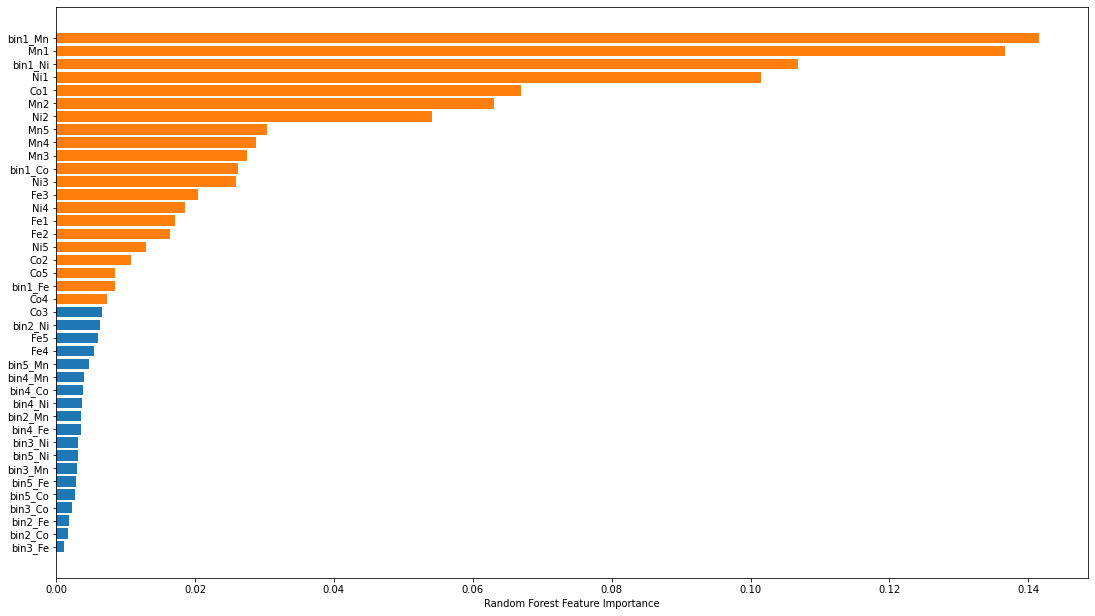

In [ ]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.barh(Name[sorted_idx], model.feature_importances_[sorted_idx])
plt.barh(select, model.feature_importances_[sorted_idx][19:40])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
# define RFE
# rfe = RFE(model, n_features_to_select=20)
# fit RFE
# rfe.fit(X_train, y_train)
# summarize all features
#for i in range(X_train.shape[1]):
#  print('Feature: %s, Selected %s, Rank: %.1f' % (Name[i], rfe.support_[i], rfe.ranking_[i]))

In [ ]:
# X_train_sel = []
# X_test_sel = []
# for i in range(X_train.shape[1]):
#  if rfe.ranking_[i] ==1:
#   X_train_sel.append(X_train[:,i])
#    X_test_sel.append(X_test[:,i])
#X_train_selected= np.array(X_train_sel)
#X_train =np.transpose(X_train_selected)
#X_test_selected = np.array(X_test_sel)
#X_test =np.transpose(X_test_selected)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)

Training Features Shape: (183, 21)
Testing Features Shape: (46, 21)


### Model: SVR

In [ ]:
cv = LeaveOneOut()
model = SVR()
scaler=StandardScaler()

pipe = Pipeline(steps=[("scaler", scaler),
                       ("modeling", model)])

# Meaning of SVR parameters
# https://datascience.stackexchange.com/questions/47769/what-is-the-possible-range-of-svr-parameters-range
# C [0,inf] - inverse regularization parameter (𝐶=0  means that we are very heavily regularizing and 𝐶→∞ no regularization)
# epsilon [0,inf] - 𝜀=0 forces the regression to penalize every point that is not exactly on the regression line. Whereas 𝜀>0 allows an indifference margin around the regression in which a deviation will not be counted as an error 
# gamma [0,inf] - For 𝛾→0 we make the kernel flatter. If 𝛾→∞ we will get a very peaked kernel

param_grid = [{"modeling__kernel": ["rbf"],
               "modeling__gamma": [1e-3],
               "modeling__C": [1000]}]

svr_rbf =  GridSearchCV(pipe,
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=cv,
                        n_jobs=-1
                        )


svr_rbf.fit(X_train, y_train)
svr_rbf.best_params_

{'modeling__C': 1000, 'modeling__gamma': 0.001, 'modeling__kernel': 'rbf'}

In [ ]:
ypred_train = svr_rbf.predict(X_train)
ypred_test = svr_rbf.predict(X_test)

stats_model_eval(y_train,ypred_train,y_test,ypred_test)

Model Performance -- Training
Training MAE= 0.061 eV
Training RMSE= 0.071 eV

Model Performance -- Test
Testing MAE= 0.062 eV
Testing RMSE= 0.078 eV


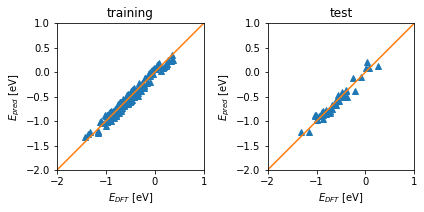

In [ ]:
plot_mod_eval(ypred_train,ypred_test)

## Learning Curve - SVR


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    svr_rbf.best_estimator_,
    X_train,
    y_train,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    return_times=True,
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

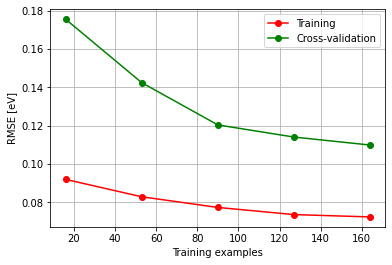

In [ ]:
# Plot learning curve

ax = plt.axes()

ax.set_xlabel("Training examples")
ax.set_ylabel("RMSE [eV]")

ax.grid()
#plt.ylim([0,0.35])
ax.plot(train_sizes, np.sqrt(-train_scores_mean), "o-", color="r", label="Training")
ax.plot(train_sizes, np.sqrt(-test_scores_mean), "o-", color="g", label="Cross-validation")

ax.legend(loc="best")

# Make prediction - SVR

In [ ]:
synfile1_100K = 'NovsynF100K_CoNiFeMn111_O_hollow_v10.csv'
syn_v10_100K = pd.read_csv(synfile1_100K, sep=',')

synfile2_100K = 'NovsynF100K_CoNiFeMn111_O_hollow_v20.csv'
syn_v20_100K = pd.read_csv(synfile2_100K, sep=',')

In [ ]:
synX_v10_100K = syn_v10_100K[syn_v10_100K['bind_type']==bind_type].iloc[:,1:]
synX_v20_100K = syn_v20_100K[syn_v20_100K['bind_type']==bind_type].iloc[:,1:]

# concatenate the features
synXdf_100K = pd.concat([synX_v10_100K, synX_v20_100K],axis=1)

# select features needed and transform to numpy arrays
synXdf_selected_100K = synXdf_100K[select]
#synXdf_selected_100K = synXdf_selected_100K.values

In [ ]:
import csv
syn_pred_100K = svr_rbf.predict(synXdf_selected_100K)
round_off_predictions_100K = np.around(syn_pred_100K, decimals = 4)
out3 = np.reshape(round_off_predictions_100K, (round_off_predictions_100K.shape[0], 1))
file = open(r'xMnO_pred100K_norm_mm.csv', 'w+', newline ='') 
with file:     
    write = csv.writer(file) 
    write.writerows(out3)